# **Human facial landmark detection with dlib library**

In [ ]:
__author__ = "Khanh An"
__email__ = "ankhanhnguyen559@gmail.com", "tiffanylarcher559@gmail.com"

#Part 1: Introduction

 This program is the application of human facial bounding box and landmarks detection from dlib library. The goal is to extract the 2D landmarks coordinates in the dataset, which will be used for further improvement in face-classification model accurary.

###Dataset information

[The iBUG 300W-dataset](https://ibug.doc.ic.ac.uk/resources/300-W/) (300 Faces-In-The-Wild) is firstly introduced by Christos Sagonas et al. in [300 Faces in-the-Wild Challenge: The First Facial Landmark Localization Challenge](https://doi.org/10.1109/ICCVW.2013.59). Here, we use the 300w dataset from [Deeplake database](https://github.com/activeloopai/deeplake). There are 599 vary-in-size images comprised of 299 Outdoor and 300 Indoor images, each image is annotated with 68-points landmarks (or keypoints) for one face only. However, in the following application using dlib, we can extract landmarks on more faces in each image than the dataset.

#Part 2: Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
%cd /content/drive/MyDrive/ComputerVision/Landmark

/content/drive/MyDrive/ComputerVision/Landmark


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

#Part 3: Prepare dataset

In [3]:
!pip3 install deeplake

In [4]:
import deeplake

In [5]:
# Retrieve 300w dataset
# https://datasets.activeloop.ai/docs/ml/datasets/300w-dataset/

ds = deeplake.load("hub://activeloop/300w")

Opening dataset in read-only mode as you don't have write permissions.


/

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/300w



\

hub://activeloop/300w loaded successfully.



In [6]:
# Overview of the dataset
ds.summary()

Dataset(path='hub://activeloop/300w', read_only=True, tensors=['images', 'keypoints', 'labels'])

  tensor        htype                   shape                dtype  compression
  -------      -------                 -------              -------  ------- 
  images        image       (599, 121:4800, 121:5616, 1:3)   uint8    jpeg   
 keypoints  keypoints_coco          (599, 204, 1)            int32    None   
  labels     class_label               (599, 1)             uint32    None   


In [7]:
# Visualize the images and overlaid landmarks
ds.visualize()

HINT: Please forward the port - 39707 to your local machine, if you are running on the cloud.
 * Serving Flask app 'dataset_visualizer'


 * Debug mode: off


In [8]:
# Convert DeepLake dataset to TensorFlow Datasets for data processing
dataloader = ds.tensorflow()

In [9]:
# Suffle dataset
dataloader = dataloader.shuffle(200)

In [10]:
type(dataloader)

deeplake.integrations.tf.deeplake_tensorflow_dataset.DatasetAdapter

Function to illustrate with some examples

In [17]:
def each_img(item):
   # Label
    if int(item['labels']) == 1:
      label = 'Outdoor'
    else: label = 'Indoor'

    # Keypoints:
    keys = item['keypoints']
    ## Convert all landmarks to an array and eliminate n+2th elements
    n = 0
    landmarks = []
    for key in keys:
      if n != 2:
        landmarks.append(int(key))
        n += 1
      else: n=0
    landmarks = np.array(landmarks)
    ## Group every 2 elements
    landmarks = landmarks.reshape(-1, 2)

    # Image:
    img = item['images'].numpy()
    ## Overlay keypoints on image
    size_mark = int(0.5*np.sqrt(np.shape(img)[0]**2+np.shape(img)[1]**2)/100)
    for landmark in landmarks:
      cv2.circle(img, (int(landmark[0]), int(landmark[1])), size_mark, (255, 0, 0), -1)
    plt.imshow(img)
    plt.title(label)

    return img, landmarks, label

def show_img_with_landmarks(dataset_adapter, num_img: int()):
  for file in dataset_adapter.take(num_img):
    plt.figure()
    img, landmarks, label = each_img(file)

### Create train and test sets

In [12]:
image_count = 599   #len(list(dataloader))
train_size = int(image_count*0.8)
train_ds = dataloader.take(train_size)
test_ds = dataloader.skip(train_size)

Visualize some images in each sets

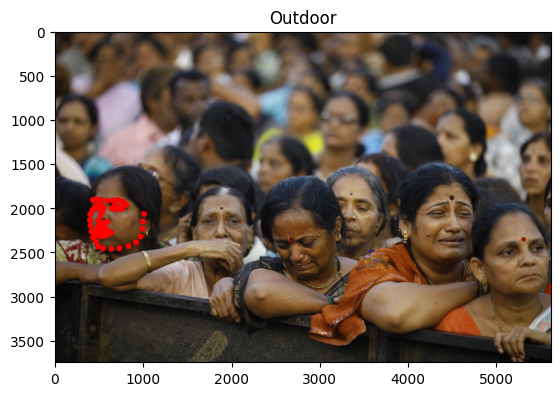

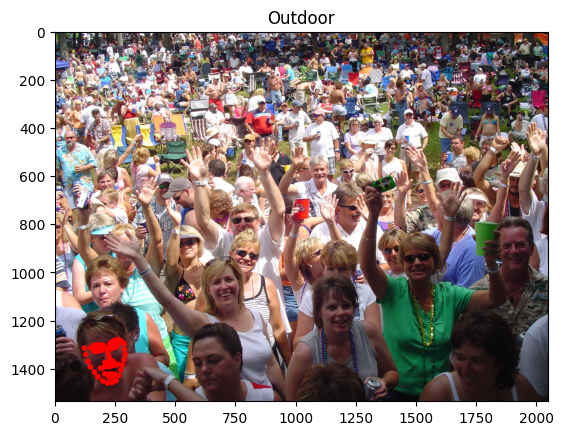

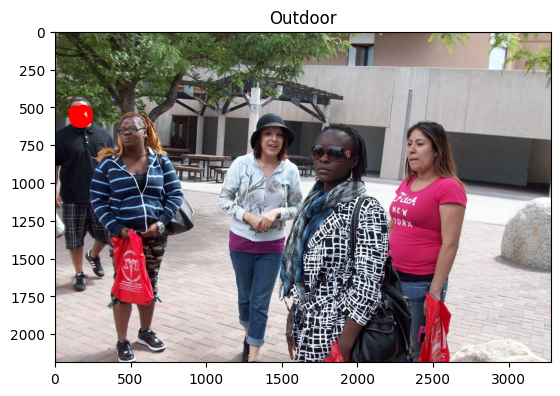

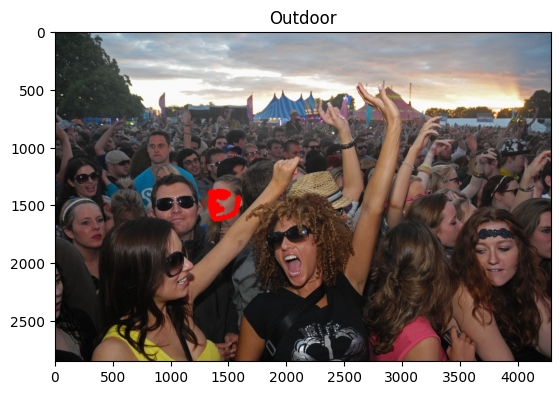

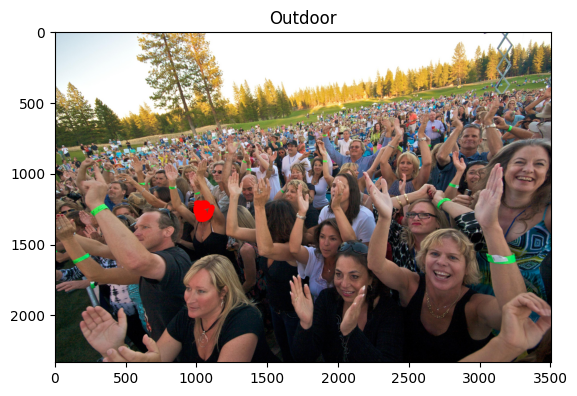

In [18]:
show_img_with_landmarks(train_ds, num_img = 5)

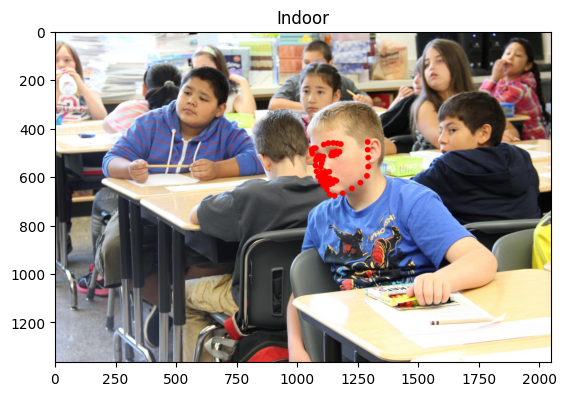

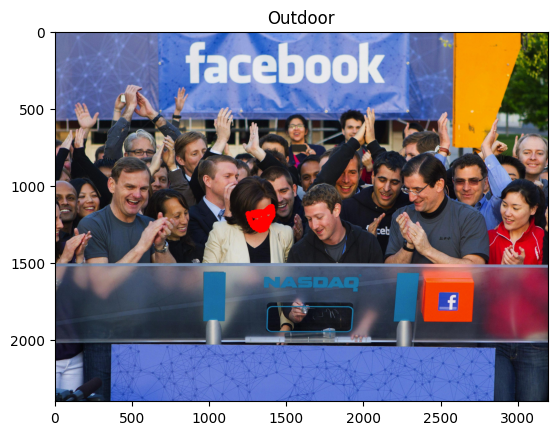

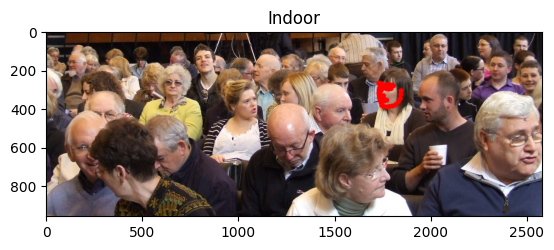

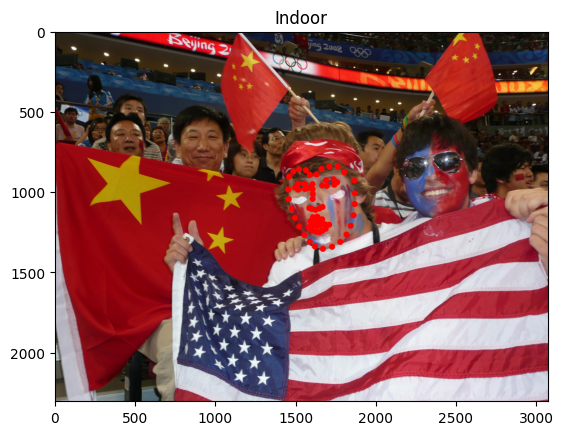

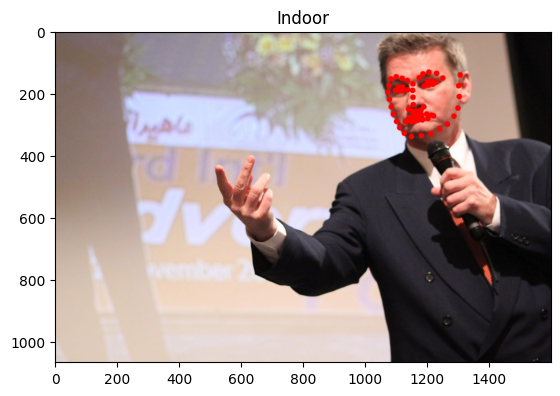

In [19]:
show_img_with_landmarks(test_ds, num_img = 5)

####Check length of sets (optional)

In [ ]:
len(list(dataloader))

599

In [ ]:
len(list(train_ds))

479

In [ ]:
len(list(test_ds))

120

#Part 4: Landmark detection with dlib

In [20]:
import dlib

In [21]:
from imutils import face_utils

In [22]:
from itertools import islice

##Download 68-landmark trained facial shape predictor model from dlib.net and extract (optional)

*Note: This model was trained on [the iBUG 300-W face landmark dataset](https://ibug.doc.ic.ac.uk/resources/facial-point-annotations/) which is the same dataset we use here, but it can detect multiple faces in an image compared to our dataset from deeplake (more info in dlib.net)*

In [ ]:
# !!! CAN SKIP IF YOU ALREADY HAVE THE MODEL !!!
#!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 -P /content/drive/MyDrive/ComputerVision/Landmark/dlib
#!bunzip2 /content/drive/MyDrive/ComputerVision/Landmark/dlib/shape_predictor_68_face_landmarks.dat.bz2

--2024-05-06 13:28:36--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘/content/drive/MyDrive/ComputerVision/Landmark/dlib/shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  43.7MB/s    in 1.4s    

2024-05-06 13:28:37 (43.7 MB/s) - ‘/content/drive/MyDrive/ComputerVision/Landmark/dlib/shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



##Visualize prediction

Initialize parameters

In [23]:
# Set path to model
predictor_dir = '/content/drive/MyDrive/ComputerVision/Landmark/dlib/shape_predictor_68_face_landmarks.dat'

In [24]:
# Face dectection
detector = dlib.get_frontal_face_detector()
# Detect facial landmarks from trained model
predictor = dlib.shape_predictor(predictor_dir)

Define function for dlib landmark detecting visualization with the control of number of face detection in an image

> *Note: the detected face from prediction may not match the original face in the dataset for multi-face images*



In [25]:
def test_each_img(item, num_face: int(), plot: bool(), info: bool()):
  # Image
  img = item['images'].numpy()

  # Face detection and landmarks
  ## Find the bounding boxes of each face and upsample img 1 time for larger view
  dets = detector(img, 1)
  print("Number of all possible faces detected: {}".format(len(dets)))

  ## Control the number of face detection
  if num_face == 0:
    limit = len(dets)
  else: limit = num_face

  ## Iterate through each face in a image
  detections_img = []      # Create a list to store dlib.full_object_detection objects

  for index, d in enumerate(islice(dets, limit)):
    ### Get the landmarks/parts for the face in box d and return in numpy
    shape = predictor(img, d)

    ### Store the bounding box and landmarks
    detections_img.append(shape)

    ### Get face boxes coordinates in cv2
    shape = face_utils.shape_to_np(shape)
    (x, y, w, h) = face_utils.rect_to_bb(d)

    ### Illustrate
    #### all bounding boxes
    line_thickness = int(0.3*np.sqrt(np.shape(img)[0]**2+np.shape(img)[1]**2)/100)
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), line_thickness)

    #### predicted landmarks
    size_mark = int(0.5*np.sqrt(np.shape(img)[0]**2+np.shape(img)[1]**2)/100)
    for landmark in shape:
      cv2.circle(img, (int(landmark[0]), int(landmark[1])), size_mark, (255, 0, 0), -1)

    ### Info
    if info == True:
      print("Detection {}: Left: {} Top: {} Right: {} Bottom: {}".format(k, d.left(), d.top(), d.right(), d.bottom()))
      '''print("Part 0: {}, Part 1: {} ...".format(shape.part(0), shape.part(1)))'''

  # Show and compare original landmarks vs predicted landmarks from dlib
  if plot == True:
    plt.figure(figsize=(12,8), dpi= 100)
    plt.subplot(121)
    plt.imshow(img)
    plt.title('dlib landmarks')
    plt.subplot(122)
    img_original, landmarks_original, label_original = each_img(item)
    plt.title('original landmarks')

  return img, detections_img


def dlib_test(set, num_img: int(), num_face: int(), plot=True, info=False):
  for file in set.take(num_img):
    img, detections_img = test_each_img(file, num_face=num_face, plot=plot, info=info)

Number of all possible faces detected: 1
Number of all possible faces detected: 4
Number of all possible faces detected: 1


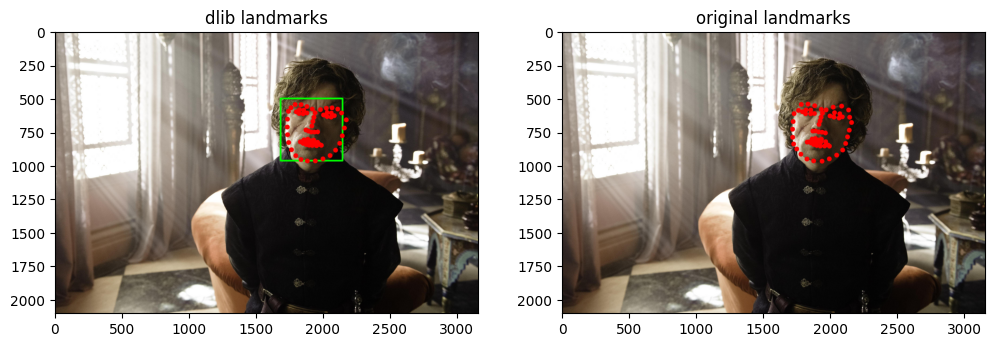

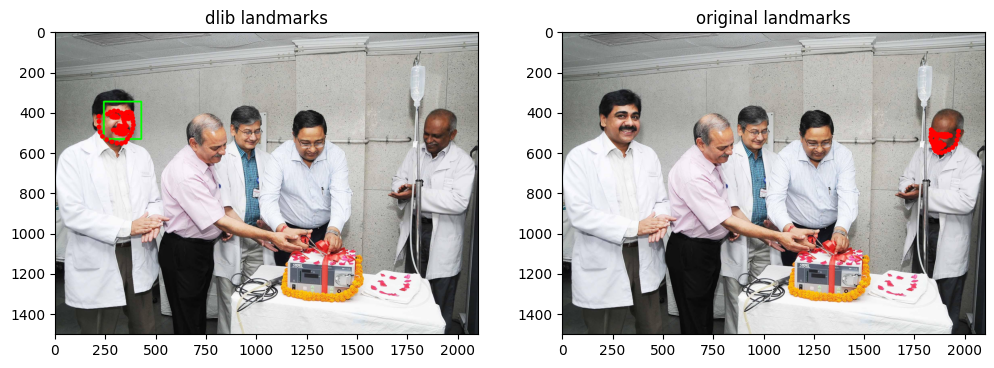

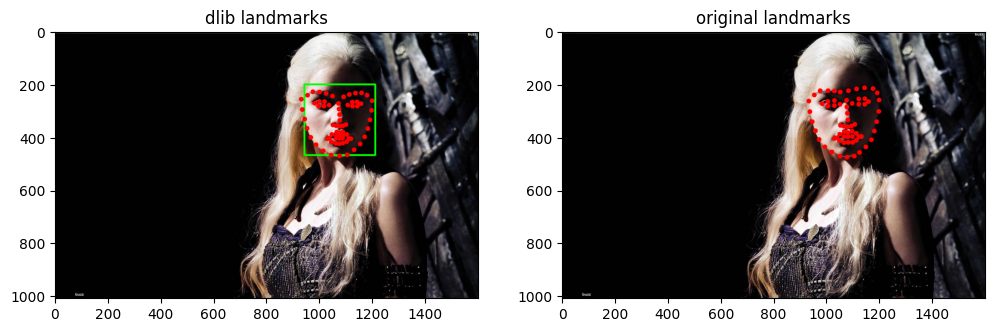

In [26]:
dlib_test(test_ds, num_img = 3, num_face = 1)

#Part 5: Evaluation

Create a list of images and a list of detections for input of the built-in evaluating function of dlib

In [28]:
def evaluate_set(set, num_face: int()):
  imgs = []           # numpy matrices
  detections = []     # dlib.full_object_detection objects

  for file in set:
    img, detections_img = test_each_img(file, num_face=num_face, plot=False, info=False)
    imgs.append(img)
    detections.append(detections_img)

  return imgs, detections

In [29]:
imgs, dets = evaluate_set(test_ds, num_face = 1)

Number of all possible faces detected: 2
Number of all possible faces detected: 1
Number of all possible faces detected: 6
Number of all possible faces detected: 1
Number of all possible faces detected: 2
Number of all possible faces detected: 8
Number of all possible faces detected: 4
Number of all possible faces detected: 2
Number of all possible faces detected: 1
Number of all possible faces detected: 3
Number of all possible faces detected: 1
Number of all possible faces detected: 1
Number of all possible faces detected: 3
Number of all possible faces detected: 1
Number of all possible faces detected: 2
Number of all possible faces detected: 5
Number of all possible faces detected: 1
Number of all possible faces detected: 0
Number of all possible faces detected: 1
Number of all possible faces detected: 1
Number of all possible faces detected: 2
Number of all possible faces detected: 2
Number of all possible faces detected: 1
Number of all possible faces detected: 74
Number of all p

In [30]:
len(imgs)

120

In [31]:
len(dets)

120

Evaluate the prediction using the mean average error (more info: http://dlib.net/python/index.html#dlib_pybind11.test_shape_predictor)

> *The difference faces detected in an image between the original dataset vs the prediction should influence the results*



In [32]:
avg_error = dlib.test_shape_predictor(imgs, dets, predictor)
print("\nTraining accuracy: {}".format(avg_error))


Training accuracy: 9.770885617790915


#Part 6: Conclusion

###References

C. Sagonas, E. Antonakos, G, Tzimiropoulos, S. Zafeiriou, M. Pantic. 300 faces In-the-wild challenge: Database and results. Image and Vision Computing (IMAVIS), Special Issue on Facial Landmark Localisation "In-The-Wild". 2016.

C. Sagonas, G. Tzimiropoulos, S. Zafeiriou, M. Pantic. 300 Faces in-the-Wild Challenge: The first facial landmark localization Challenge. Proceedings of IEEE Int’l Conf. on Computer Vision (ICCV-W), 300 Faces in-the-Wild Challenge (300-W). Sydney, Australia, December 2013.

C. Sagonas, G. Tzimiropoulos, S. Zafeiriou, M. Pantic. A semi-automatic methodology for facial landmark annotation. Proceedings of IEEE Int’l Conf. Computer Vision and Pattern Recognition (CVPR-W), 5th Workshop on Analysis and Modeling of Faces and Gestures (AMFG 2013). Oregon, USA, June 2013.

http://dlib.net

https://github.com/huytranvan2010/Facial-landmarks-with-dlib-OpenCV

https://github.com/codebasics/deep-learning-keras-tf-tutorial/tree/master

